# Backtesting with [**vectorbt**](https://github.com/polakowo/vectorbt)
* Data Acquisition (**yfinance**)
* Statistical and Technical Analysis (**pandas_ta**)
* Backtesting Analysis and Results (**vectorbt**)

### Initializations

In [1]:
!pip install vectorbt


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import asyncio
import itertools
from datetime import datetime

from IPython import display

import numpy as np
import pandas as pd
import pandas_ta as ta
import vectorbt as vbt

import plotly.graph_objects as go

from utils import *
from myInds import *

print("Package Versions:")
print(f"Numpy v{np.__version__}")
print(f"Pandas v{pd.__version__}")
print(f"vectorbt >= v0.18.1")
print(f"\nPandas TA v{ta.version}\nTo install the Latest Version:\n$ pip install -U git+https://github.com/twopirllc/pandas-ta\n")

%matplotlib inline


Bad key text.latex.preview in file C:\Users\steve\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\steve\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\steve\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

Package Versions:
Numpy v1.21.6
Pandas v1.3.5
vectorbt >= v0.18.1

Pandas TA v0.3.14b0
To install the Latest Version:
$ pip install -U git+https://github.com/twopirllc/pandas-ta



# **vectorbt** Theme and Portfolio Settings

In [2]:
cheight, cwidth = 500, 1000 # Adjust as needed for Chart Height and Width
vbt.settings.set_theme("dark") # Options: "light" (Default), "dark" (my fav), "seaborn"

# Must be set
vbt.settings.portfolio["freq"] = "1d" # Daily

# Predefine vectorbt Portfolio settings
# vbt.settings.portfolio["init_cash"] = 100
vbt.settings.portfolio["fees"] = 0.00 # 0.25%
vbt.settings.portfolio["slippage"] = 0.00 # 0.25%
# vbt.settings.portfolio["size"] = 100
# vbt.settings.portfolio["accumulate"] = False
vbt.settings.portfolio["allow_partial"] = False

pf_settings = pd.DataFrame(vbt.settings.portfolio.items(), columns=["Option", "Value"])
pf_settings.set_index("Option", inplace=True)

print(f"Portfolio Settings [Initial]")
pf_settings

Portfolio Settings [Initial]


,Value
Option,
call_seq,default
init_cash,100.0
size,inf
size_type,amount
fees,0.0
...,...
attach_call_seq,False
fillna_close,True
trades_type,exittrades


## Helper Methods

In [3]:
# def combine_stats(pf: vbt.portfolio.base.Portfolio, ticker: str, strategy: str, mode: int = 0):
#     header = pd.Series({
#         "Run Time": ta.get_time(full=False, to_string=True),
#         "Mode": "LIVE" if mode else "TEST",
#         "Strategy": strategy,
#         "Direction": vbt.settings.portfolio["signal_direction"],
#         "Symbol": ticker.upper(),
#         "Fees [%]": 100 * vbt.settings.portfolio["fees"],
#         "Slippage [%]": 100 * vbt.settings.portfolio["slippage"],
#         "Accumulate": vbt.settings.portfolio["accumulate"],
#     })
#     rstats = pf.returns_stats().dropna(axis=0).T
#     stats = pf.stats().dropna(axis=0).T
#     joint = pd.concat([header, stats, rstats])
#     return joint[~joint.index.duplicated(keep="first")]

# def earliest_common_index(d: dict):
#     """Returns index of the earliest common index of all DataFrames in the dict"""
#     min_date = None
#     for df in d.values():
#         if min_date is None:
#             min_date = df.index[0]
#         elif min_date < df.index[0]:
#             min_date = df.index[0]
#     return min_date

# def dl(tickers: list, same_start: bool = False, **kwargs):
#     if isinstance(tickers, str):
#         tickers = [tickers]
    
#     if not isinstance(tickers, list) or len(tickers) == 0:
#         print("Must be a non-empty list of tickers or symbols")
#         return

#     if "limit" in kwargs and kwargs["limit"] and len(tickers) > kwargs["limit"]:
#         from itertools import islice            
#         tickers = list(islice(tickers, kwargs["limit"]))
#         print(f"[!] Too many assets to compare. Using the first {kwargs['limit']}: {', '.join(tickers)}")

#     print(f"[i] Downloading: {', '.join(tickers)}")

#     received = {}
#     if len(tickers):
#         _df = pd.DataFrame()
#         for ticker in tickers:
#             received[ticker] = _df.ta.ticker(ticker, **kwargs)
#             print(f"[+] {ticker}{received[ticker].shape} {ta.get_time(full=False, to_string=True)}")
    
#     if same_start and len(tickers) > 1:
#         earliestci = earliest_common_index(received)
#         print(f"[i] Earliest Common Date: {earliestci}")
#         result = {ticker:df[df.index > earliestci].copy() for ticker,df in received.items()}
#     else:
#         result = received
#     print(f"[*] Download Complete\n")
#     return result

# def dtmask(df: pd.DataFrame, start: datetime, end: datetime):
#     df['Datetime'] = pd.to_datetime(df.index, utc=True)
#     print(df['Datetime'])
#     if not df.ta.datetime_ordered:
#         df = df.set_index(pd.DatetimeIndex(df['Datetime']))    
#     return df.loc[(df.index >= pd.to_datetime(start, utc=True)) & (df.index <= pd.to_datetime(end, utc=True)), :].copy()

# def show_data(d: dict):
#     [print(f"{t}[{df.index[0]} - {df.index[-1]}]: {df.shape} {df.ta.time_range:.2f} years") for t,df in d.items()]
    
# def trade_table(pf: vbt.portfolio.base.Portfolio, k: int = 1, total_fees: bool = False):
#     if not isinstance(pf, vbt.portfolio.base.Portfolio): return
#     k = int(k) if isinstance(k, int) and k > 0 else 1

#     df = pf.trades.records[["status", "direction", "size", "entry_price", "exit_price", "return", "pnl", "entry_fees", "exit_fees"]]
#     if total_fees:
#         df["total_fees"] = df["entry_fees"] + df["exit_fees"]
# #     df.to_excel("trade_udow_2016to2023_exits.xlsx")
#     print(f"\nLast {k} of {df.shape[0]} Trades\n{df.tail(k)}\n")

# Data Acquisition

#### Specify Symbols for Benchmarks and Assets

In [2]:
benchmark_tickers = ["SPY", "QQQ"]
asset_tickers = ["AAPL", "TSLA", "BLK","NFLX","MSFT","TSM","SOXL","DHI","HD",
                 "COIN", "U", 
                 "ENPH","TSM",
                 "QCOM","BX",
                 "AMD","NVDA",
                 "MRNA","GUSH",
                 "WSM","MCD",
                 "TLT","TAN",
                "TNA", "TQQQ","UDOW","FAS","QQQ","SPY","UDOW"]
all_tickers = benchmark_tickers + asset_tickers

print("Tickers by index #")
print("="*100)
print(f"Benchmarks: {', '.join([f'{k}: {v}' for k,v in enumerate(benchmark_tickers)])}")
print(f"    Assets: {', '.join([f'{k}: {v}' for k,v in enumerate(asset_tickers)])}")
print(f"       All: {', '.join([f'{k}: {v}' for k,v in enumerate(all_tickers)])}")

Tickers by index #
Benchmarks: 0: SPY, 1: QQQ
    Assets: 0: AAPL, 1: TSLA, 2: BLK, 3: NFLX, 4: MSFT, 5: TSM, 6: SOXL, 7: DHI, 8: HD, 9: COIN, 10: U, 11: ENPH, 12: TSM, 13: QCOM, 14: BX, 15: AMD, 16: NVDA, 17: MRNA, 18: GUSH, 19: WSM, 20: MCD, 21: TLT, 22: TAN, 23: TNA, 24: TQQQ, 25: UDOW, 26: FAS, 27: QQQ, 28: SPY, 29: UDOW
       All: 0: SPY, 1: QQQ, 2: AAPL, 3: TSLA, 4: BLK, 5: NFLX, 6: MSFT, 7: TSM, 8: SOXL, 9: DHI, 10: HD, 11: COIN, 12: U, 13: ENPH, 14: TSM, 15: QCOM, 16: BX, 17: AMD, 18: NVDA, 19: MRNA, 20: GUSH, 21: WSM, 22: MCD, 23: TLT, 24: TAN, 25: TNA, 26: TQQQ, 27: UDOW, 28: FAS, 29: QQQ, 30: SPY, 31: UDOW


In [3]:
benchmark = benchmark_tickers[0] # Change index for different benchmark
asset = asset_tickers[2] # Change index for different symbol
print(f"Selected Benchmark | Asset: {benchmark} | {asset}")

Selected Benchmark | Asset: SPY | BLK


In [4]:
# benchmarks = dl(benchmark_tickers, lc_cols=True)
tf = "1d"
benchmarks = retrieve_data(benchmark_tickers, tf=tf)


[!] Loading All: SPY, QQQ
C:\Users\steve\av_data\data\SPY_1d.csv
[i] Loaded SPY[1d]: SPY_1d.csv
[i] Runtime: 1275.7196 ms (1.2757 s)
C:\Users\steve\av_data\data\QQQ_1d.csv
[i] Loaded QQQ[1d]: QQQ_1d.csv
[i] Runtime: 1273.9509 ms (1.2740 s)


In [5]:
# assets = dl(asset_tickers, lc_cols=True)
assets = retrieve_data(asset_tickers, tf=tf)

assets.tickers

[!] Loading All: AAPL, TSLA, BLK, NFLX, MSFT, TSM, SOXL, DHI, HD, COIN, U, ENPH, TSM, QCOM, BX, AMD, NVDA, MRNA, GUSH, WSM, MCD, TLT, TAN, TNA, TQQQ, UDOW, FAS, QQQ, SPY, UDOW
C:\Users\steve\av_data\data\AAPL_1d.csv
[i] Loaded AAPL[1d]: AAPL_1d.csv
[i] Runtime: 1260.0021 ms (1.2600 s)
C:\Users\steve\av_data\data\TSLA_1d.csv
[i] Loaded TSLA[1d]: TSLA_1d.csv
[i] Runtime: 1261.5147 ms (1.2615 s)
C:\Users\steve\av_data\data\BLK_1d.csv
[i] Loaded BLK[1d]: BLK_1d.csv
[i] Runtime: 1274.2443 ms (1.2742 s)
C:\Users\steve\av_data\data\NFLX_1d.csv
[i] Loaded NFLX[1d]: NFLX_1d.csv
[i] Runtime: 1247.2256 ms (1.2472 s)
C:\Users\steve\av_data\data\MSFT_1d.csv
[i] Loaded MSFT[1d]: MSFT_1d.csv
[i] Runtime: 1266.9936 ms (1.2670 s)
C:\Users\steve\av_data\data\TSM_1d.csv
[i] Loaded TSM[1d]: TSM_1d.csv
[i] Runtime: 1270.3436 ms (1.2703 s)
C:\Users\steve\av_data\data\SOXL_1d.csv
[i] Loaded SOXL[1d]: SOXL_1d.csv
[i] Runtime: 1249.3665 ms (1.2494 s)
C:\Users\steve\av_data\data\DHI_1d.csv
[i] Loaded DHI[1d]: D

['AAPL',
 'TSLA',
 'BLK',
 'NFLX',
 'MSFT',
 'TSM',
 'SOXL',
 'DHI',
 'HD',
 'COIN',
 'U',
 'ENPH',
 'TSM',
 'QCOM',
 'BX',
 'AMD',
 'NVDA',
 'MRNA',
 'GUSH',
 'WSM',
 'MCD',
 'TLT',
 'TAN',
 'TNA',
 'TQQQ',
 'UDOW',
 'FAS',
 'QQQ',
 'SPY',
 'UDOW']

### Define Testing Dates and Ranges

In [7]:
start_date = datetime(2016, 12, 5) # Adjust as needed
end_date = datetime(2023, 9, 29)   # Adjust as needed

### Select and Benchmark and Asset to Backtest

In [8]:
print("Available Data:")
print("="*100)
print(f"Benchmarks: {', '.join(benchmarks.tickers)}")
print(f"Assets: {', '.join(assets.tickers)}")

Available Data:
Benchmarks: SPY, QQQ
Assets: AAPL, TSLA, BLK, NFLX, MSFT, TSM, SOXL, DHI, HD, COIN, U, ENPH, TSM, QCOM, BX, AMD, NVDA, MRNA, GUSH, WSM, MCD, TLT, TAN, TNA, TQQQ, UDOW, FAS, QQQ, SPY, UDOW


In [10]:
benchmark_name = "SPY" # Select a Benchmark
asset_name = "UDOW" # Select an Asset

benchmarkdf = benchmarks.data[benchmark_name]
benchmarkdf = add_jc_data(benchmarkdf)

assetdf     = assets.data[asset_name]
assetdf = add_jc_data(assetdf)
# print(temp.columns)

# print(assetdf.columns)
# Set True if you want to constrain Data between start_date & end_date
common_range = True
if common_range:
    crs = f" from {start_date} to {end_date}"
    benchmarkdf = dtmask(benchmarkdf, start_date, end_date)
    assetdf = dtmask(assetdf, start_date, end_date)

# Update DataFrame names
benchmarkdf.name = benchmark_name
assetdf.name = asset_name
print(f"Analysis of: {benchmarkdf.name} and {assetdf.name}{crs if common_range else ''}")

Datetime
1993-01-29 05:00:00+00:00   1993-01-29 05:00:00+00:00
1993-02-01 05:00:00+00:00   1993-02-01 05:00:00+00:00
1993-02-02 05:00:00+00:00   1993-02-02 05:00:00+00:00
1993-02-03 05:00:00+00:00   1993-02-03 05:00:00+00:00
1993-02-04 05:00:00+00:00   1993-02-04 05:00:00+00:00
                                       ...           
2023-09-26 04:00:00+00:00   2023-09-26 04:00:00+00:00
2023-09-27 04:00:00+00:00   2023-09-27 04:00:00+00:00
2023-09-28 04:00:00+00:00   2023-09-28 04:00:00+00:00
2023-09-29 04:00:00+00:00   2023-09-29 04:00:00+00:00
2023-10-02 04:00:00+00:00   2023-10-02 04:00:00+00:00
Name: Datetime, Length: 7724, dtype: datetime64[ns, UTC]
Datetime
2010-02-11 05:00:00+00:00   2010-02-11 05:00:00+00:00
2010-02-12 05:00:00+00:00   2010-02-12 05:00:00+00:00
2010-02-16 05:00:00+00:00   2010-02-16 05:00:00+00:00
2010-02-17 05:00:00+00:00   2010-02-17 05:00:00+00:00
2010-02-18 05:00:00+00:00   2010-02-18 05:00:00+00:00
                                       ...           
2023-09

#### Sanity Check

In [76]:
benchmarkdf

,Open,High,...,rkprice,deltaclose
Datetime,,,,,
2016-12-05 05:00:00+00:00,195.389557,196.053695,...,99.0,1.168884
2016-12-06 05:00:00+00:00,195.894291,196.354764,...,100.0,0.619843
2016-12-07 05:00:00+00:00,196.159932,198.949308,...,100.0,2.567993
2016-12-08 05:00:00+00:00,198.860831,199.861458,...,100.0,0.487091
2016-12-09 05:00:00+00:00,199.604658,200.596434,...,100.0,1.204300
...,...,...,...,...,...
2023-09-22 04:00:00+00:00,432.450012,434.100006,...,30.0,-0.970001
2023-09-25 04:00:00+00:00,429.170013,432.269989,...,33.0,1.809998
2023-09-26 04:00:00+00:00,429.089996,429.820007,...,25.0,-6.350006


In [77]:
assetdf[['Close', 'SMA_50','rk50', 'rk100', 'rk250', 'rkprice']]
# assetdf.index = assetdf.index.tz_localize(None)
# assetdf[['Close', 'SMA_50','SMA_100','SMA_250','rk50', 'rk100', 'rk250', 'rkprice','deltaclose','cmb_rk']].to_excel("udow_2018to2023.xlsx")

,Close,SMA_50,...,rk250,rkprice
Datetime,,,,,
2016-12-05 05:00:00+00:00,20.878222,18.480856,...,250.0,100.0
2016-12-06 05:00:00+00:00,21.017635,18.554793,...,250.0,100.0
2016-12-07 05:00:00+00:00,21.986309,18.639978,...,250.0,100.0
2016-12-08 05:00:00+00:00,22.238697,18.724011,...,250.0,100.0
2016-12-09 05:00:00+00:00,22.760292,18.829483,...,250.0,100.0
...,...,...,...,...,...
2023-09-22 04:00:00+00:00,56.160000,61.185541,...,93.0,23.0
2023-09-25 04:00:00+00:00,56.380001,61.115681,...,100.0,28.0
2023-09-26 04:00:00+00:00,54.380001,60.999638,...,58.0,10.0


## Creating Trading Signals for **vectorbt**
**vectorbt** can create a Backtest using ```vbt.Portfolio.from_signals(*args, **kwargs)``` based on trends can you define with **Pandas TA**.

### Trend Creation
A **Trend** is the result of some calculation or condition of one or more indicators. For simplicity, a _Trend_ is either ```True``` or ```1``` and _No Trend_ is ```False``` or ```0```. Using the **Hello World** of Trends, the **Golden/Death Cross**, it's Trend is _Long_ when ```long = ma(close, 50) > ma(close, 200) ``` and _Short_ when ```short = ma(close, 50) < ma(close, 200) ```. 

In [78]:
# RSI = vbt.IndicatorFactory.from_talib('RSI')
# window_delta = 10
# def custom_indicator_obv(close, volumn, rsi_window, ma_window_slow,  entry, exit):
#     close_5m = close.resample("5T").last()
#     print("close_tm",close_5m)
# #     rsi = vbt.RSI.run(close,  window = rsi_window).rsi
#     obv = vbt.OBV.run(close,  window = rsi_window).rsi
# #     print("rsi", rsi)
#     ma_window_fast = ma_window_slow - window_delta
#     ma_slow = vbt.MA.run(close, ma_window_slow).ma.to_numpy()
#     ma_fast = vbt.MA.run(close, ma_window_fast).ma.to_numpy()
#     trend = np.where(rsi > exit , -1, 0)
#     trend = np.where( (rsi < entry) & (close < ma), 1, trend)
#     return trend

# def custom_indicator(close, rsi_window, ma_window_slow,  entry, exit):
# #     close_5m = close.resample("5T").last()
# #     print("close_tm",close_5m)
#     rsi = vbt.RSI.run(close,  window = rsi_window).rsi
# #     obv = vbt.OBV.run(close,  window = rsi_window).rsi
# #     print("rsi", rsi)
#     ma_window_fast = ma_window_slow - window_delta
#     ma_slow = vbt.MA.run(close, ma_window_slow).ma.to_numpy()
#     ma_fast = vbt.MA.run(close, ma_window_fast).ma.to_numpy()    
#     trend = np.where((rsi > exit) & (ma_fast < ma_slow), -1, 0)
#     trend = np.where( (rsi < entry) & ( ma_fast > ma_slow), 1, trend)
#     return trend

# def custom_indicator_1m(close, rsi_window = 14,ma_window_slow = 20,  entry = 30, exit = 70):
#     close_5m = close.resample("5T").last()
# #     print(close_5m)
#     rsi = vbt.RSI.run(close_5m,  window = rsi_window).rsi
#     rsi, _= rsi.align(close, 
#                       broadcast_axis = 0,
#                      method = 'ffill',
#                      join = 'right')
#     rsi = rsi.to_numpy()
#     close = close.to_numpy()
#     ma_window_fast = ma_window_slow - window_delta
#     ma_slow = vbt.MA.run(close, ma_window_slow).ma.to_numpy()
#     ma_fast = vbt.MA.run(close, ma_window_fast).ma.to_numpy()
#     trend = np.where(rsi > exit , -1, 0)
#     trend = np.where( (rsi < entry) & (close < ma), 1, trend)
#     return trend

# def jinsong_indicator(rk50, rk100, rk250, rkprice,   entry, exit):
#     trend = np.where((((rk50 + rk100)*100/150) >= exit) & (rk100 >= exit), -1, 0)
#     trend = np.where( (((rk50 + rk100)*100/150) <= entry) & ((rk100 <= entry)| (rk250 == 1)), 1, trend)
#     return trend

# def jinsong_indicator_doublecheck(rk50, rk100, rk250, rkprice, deltaclose,  entry, exit):
#     trend = np.where((((rk50 + rk100)/150*100)>= exit) & (rk100 >= exit) & (deltaclose<0), -1, 0)
#     trend = np.where( (((rk50 + rk100)/150*100)<= entry) & (rk100 <= entry)& (deltaclose>0), 1, trend)
#     return trend

IndentationError: unexpected indent (<ipython-input-78-69ced2e823b4>, line 54)

In [11]:
jc_ind = vbt.IndicatorFactory(
    class_name = "Jinsong",
    short_name = "js",
    input_names = ['rk50', 'rk100', 'rk250', 'rkprice'],
    param_names = ["entry", 
                   "exit"],
    output_names = ["value"]
    ).from_apply_func(
         jinsong_indicator,
         entry = 1,
         exit = 100,         
         keep_pd = True
        )

jc_ind_delta = vbt.IndicatorFactory(
    class_name = "Jinsong-delta",
    short_name = "js-delta",
    input_names = ['rk50', 'rk100', 'rk250', 'rkprice','deltaclose'],
    param_names = ["entry", 
                   "exit"],
    output_names = ["value"]
    ).from_apply_func(
         jinsong_indicator_doublecheck,
         entry = 1,
         exit = 100,         
         keep_pd = True
        )

ind = vbt.IndicatorFactory(
    class_name = "Combination",
    short_name = "comb",
    input_names = ["close"],
    param_names = ["rsi_window", 
                   "ma_window_slow", 
#                    "ma_window_fast", 
                   "entry", 
                   "exit"],
    output_names = ["value"]
    ).from_apply_func(
         custom_indicator,
         rsi_window = 14,
         ma_window_slow = 50,
#          ma_window_fast = 20,
         entry = 30,
         exit = 70,         
         keep_pd = True
        )

# rwindow = 14
# mawindow = 50
# ent = 30
# ext = 70
rwindow = np.arange(20,40, step=5, dtype=int)
mawindow_slow = np.arange(30,200, step=10, dtype=int)
# mawindow_fast = np.arange(10,80, step=20, dtype=int)
# if (mawindow_fast > mawindow_slow):
#     mawinow_fast = mawindow_slow - 20
ent = np.arange(20,40, step=5, dtype=int)
ext = np.arange(60,80, step=10, dtype=int)

# res = ind.run(assets_close,
#              rsi_window = rwindow, 
#              ma_window_slow = mawindow_slow,
# #              ma_window_fast = mawindow_fast,
#              entry = ent,
#              exit = ext,
#              param_product = True)
# # print(res.value)
# entries = res.value == 1.0
# exits = res.value == -1.0

# # print(entries)
# # print(exits)
# # print(assets_close.columns)
# pf = vbt.Portfolio.from_signals(assets_close, entries, exits)
# # fig = assets_close.vbt.plot(trace_kwargs=dict(name='Price', line=dict(color='Red')))
# # fig = tsi.vbt.plot(trace_kwargs=dict(name='Price', line=dict(color='blue')), fig=fig)
# # fig.show()
# # print(pf.trades.records_arr)
# # pf.orders.plot().show()
# # pf.plot().show()
# # print(res.value)
# # print(pf.stats())

# # print( pf.total_return())
# returns =  pf.total_return()

# # returns = returns[returns.index.isin(["TSLA"], level="symbol")]

# # returns = returns.groupby(level=["comb_exit", "comb_extry"]).mean()

# print(returns.max())
# print(returns.idxmax())


In [12]:
# Example Long Trends for the selected Asset
# * Uncomment others for exploration or replace them with your own TA Trend Strategy
def trends(df: pd.DataFrame, mamode: str = "sma", fast: int = 50, slow: int = 200):
    return ta.ma(mamode, df.close, length=fast) > ta.ma(mamode, df.close, length=slow) # SMA(fast) > SMA(slow) "Golden/Death Cross"
#     return ta.increasing(ta.ma(mamode, df.close, length=fast)) # Increasing MA(fast)
#     return ta.macd(df.close, fast, slow).iloc[:,1] > 0 # MACD Histogram is positive

def trends_rsi(df: pd.DataFrame, rsi_window: int = 14, ma_window: int = 50, entry: int = 30, exit: int = 70):
    res = ind.run(df.Close,
                 rsi_window = rsi_window, 
                 ma_window_slow = ma_window,
                 entry = entry,
                 exit = exit,
                 param_product = True)
    entries = res.value == 1.0
    exits = res.value == -1.0
#     trend = np.where(exits , -1, 0)
#     trend = np.where( entries, 1, trend)    
#     return  trend # rsi
    return entries,exits

def trends_jinsong(df: pd.DataFrame,  entry: int = 1, exit: int = 100):
    res = jc_ind.run(df.rk50, df.rk100, df.rk250, df.rkprice,
                 entry = entry,
                 exit = exit,
                 param_product = True)
    entries = res.value == 1.0
    exits = res.value == -1.0
    return entries, exits

def trends_jinsong_delta(df: pd.DataFrame,  entry: int = 1, exit: int = 98):
    res = jc_ind_delta.run(df.rk50, df.rk100, df.rk250, df.rkprice,df.deltaclose,
                 entry = entry,
                 exit = exit,
                 param_product = True)
    entries = res.value == 1.0
    exits = res.value == -1.0
    return entries, exits

### Display Trends

In [81]:
trend_kwargs = {"mamode": "sma", "fast": 50, "slow": 200}
# (35, 160, 30, 60, 'TSLA')
trend_rsi={"rsi_window": 35, "ma_window": 160, "entry": 30, "exit": 60}

trend_jinsong={"entry": 12, "exit": 99}

Datetime
2016-12-05 05:00:00+00:00    False
2016-12-06 05:00:00+00:00    False
2016-12-07 05:00:00+00:00    False
2016-12-08 05:00:00+00:00    False
2016-12-09 05:00:00+00:00    False
                             ...  
2023-09-22 04:00:00+00:00     True
2023-09-25 04:00:00+00:00     True
2023-09-26 04:00:00+00:00     True
2023-09-27 04:00:00+00:00     True
2023-09-28 04:00:00+00:00     True
Name: (12, 99), Length: 1715, dtype: bool


<AxesSubplot:title={'center':'SPY Trends'}, xlabel='Datetime'>

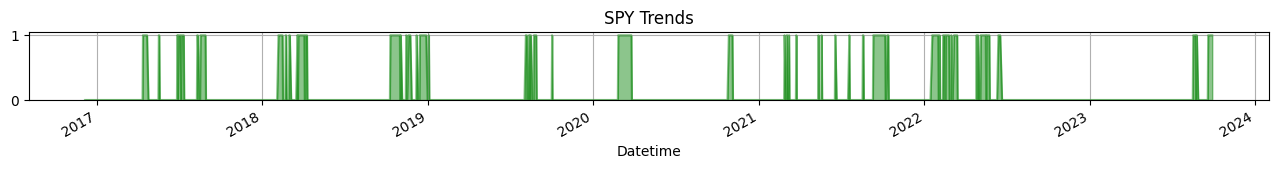

In [82]:
# benchmark_trends = trends(benchmarkdf, **trend_kwargs)
benchmark_trends, benchmark_exits = trends_jinsong(benchmarkdf, **trend_jinsong)
# benchmark_trends = trends_jinsong_delta(benchmarkdf, **trend_jinsong)

print(benchmark_trends)
benchmark_trends.copy().astype(int).plot(figsize=(16, 1), kind="area", color=["green"], alpha=0.45, title=f"{benchmarkdf.name} Trends", grid=True)

<AxesSubplot:title={'center':'UDOW Trends'}, xlabel='Datetime'>

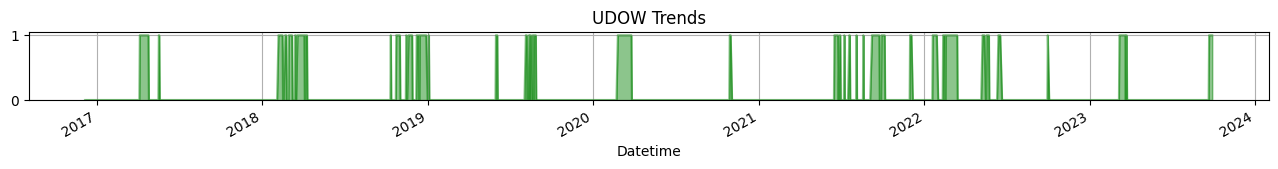

In [83]:
asset_trends, asset_exits = trends_jinsong(assetdf, **trend_jinsong)
# asset_trends = trends_jinsong_delta(benchmarkdf, **trend_jinsong)
# output = asset_trends
# output.index = asset_trends.index.tz_localize(None)
# output.to_excel("trends_udow_2018to2023_entries.xlsx")

# output = asset_exits
# output.index = asset_trends.index.tz_localize(None)
# output.to_excel("trends_udow_2018to2023_exits.xlsx")

asset_trends.copy().astype(int).plot(figsize=(16, 1), kind="area", color=["green"], alpha=0.45, title=f"{assetdf.name} Trends", grid=True)

Portfolio Settings [Initial]
[!] Loading All: SPY
C:\Users\steve\av_data\data\SPY_1d.csv
[i] Loaded SPY[1d]: SPY_1d.csv
[i] Runtime: 1488.9739 ms (1.4890 s)
Datetime
1993-01-29 05:00:00+00:00   1993-01-29 05:00:00+00:00
1993-02-01 05:00:00+00:00   1993-02-01 05:00:00+00:00
1993-02-02 05:00:00+00:00   1993-02-02 05:00:00+00:00
1993-02-03 05:00:00+00:00   1993-02-03 05:00:00+00:00
1993-02-04 05:00:00+00:00   1993-02-04 05:00:00+00:00
                                       ...           
2023-09-26 04:00:00+00:00   2023-09-26 04:00:00+00:00
2023-09-27 04:00:00+00:00   2023-09-27 04:00:00+00:00
2023-09-28 04:00:00+00:00   2023-09-28 04:00:00+00:00
2023-09-29 04:00:00+00:00   2023-09-29 04:00:00+00:00
2023-10-02 04:00:00+00:00   2023-10-02 04:00:00+00:00
Name: Datetime, Length: 7724, dtype: datetime64[ns, UTC]
Analysis of: SPY from 2016-12-05 00:00:00 to 2023-09-29 00:00:00

Last 5 of 9 Trades
   status  direction  ...  entry_fees  exit_fees
4       1          0  ...         0.0        0.0


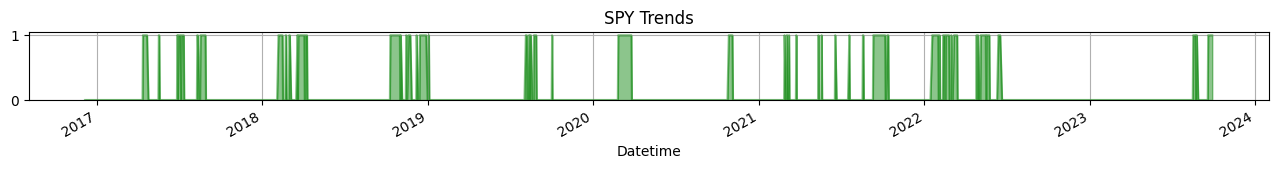

In [9]:
from pytz import timezone
import pytz

from plotly.subplots import make_subplots

cheight, cwidth = 500, 1000 # Adjust as needed for Chart Height and Width
vbt.settings.set_theme("dark") # Options: "light" (Default), "dark" (my fav), "seaborn"

# Must be set
vbt.settings.portfolio["freq"] = "1d" # Daily

# Predefine vectorbt Portfolio settings
# vbt.settings.portfolio["init_cash"] = 100
vbt.settings.portfolio["fees"] = 0.00 # 0.25%
vbt.settings.portfolio["slippage"] = 0.00 # 0.25%
# vbt.settings.portfolio["size"] = 100
# vbt.settings.portfolio["accumulate"] = False
vbt.settings.portfolio["allow_partial"] = False

pf_settings = pd.DataFrame(vbt.settings.portfolio.items(), columns=["Option", "Value"])
pf_settings.set_index("Option", inplace=True)

print(f"Portfolio Settings [Initial]")
pf_settings

# benchmark_tickers = ["SPY", "QQQ"]
# asset_tickers = ["AAPL", "TSLA", "BLK","NFLX","MSFT","TSM","SOXL","DHI","HD",
#                  "COIN", "U", 
#                  "ENPH","TSM",
#                  "QCOM","BX",
#                  "AMD","NVDA",
#                  "MRNA","GUSH",
#                  "WSM","MCD",
#                  "TLT","TAN",
#                 "TNA", "TQQQ","UDOW","FAS","QQQ","SPY","UDOW"]
# all_tickers = benchmark_tickers + asset_tickers

ticker = 'SPY'
assets = retrieve_data([ticker], tf=tf)

start_date = datetime(2016, 12, 5) # Adjust as needed
end_date = datetime(2023, 9, 29)   # Adjust as needed
datadir = '/Users/steve/av_data/trades_analysis'
startdate=datetime.now()
startdate = startdate.astimezone(timezone('US/Pacific'))
tadate = startdate.strftime('%Y-%m-%d')
tadir =os.path.join(datadir, 'ta-'+tadate)
if not os.path.exists(tadir):
    os.makedirs(tadir)    
filename=os.path.join(tadir, 'chart-'+ticker+'.jpg')
bnh_filename=os.path.join(tadir, 'chart-'+ticker+'-bnh.jpg')
    
assetdf = assets.data[ticker]
assetdf = add_jc_data(assetdf)
common_range = True
LIVE = 0
trend_jinsong={"entry": 12, "exit": 99}

if common_range:
    crs = f" from {start_date} to {end_date}"
    assetdf = dtmask(assetdf, start_date, end_date)

# Update DataFrame names
assetdf.name = ticker
print(f"Analysis of: {assetdf.name}{crs if common_range else ''}")


def show_trend(df):
    asset_trends, asset_exits = trends_jinsong(df, **trend_jinsong)
    asset_trends.copy().astype(int).plot(figsize=(16, 1), kind="area", color=["green"], alpha=0.45, title=f"{df.name} Trends", grid=True)

    # Asset Portfolio from Trade Signals
    assetpf_signals = vbt.Portfolio.from_signals(
        df.Close,
        signal_args=(vbt.Rep("entries"), vbt.Rep("exits")),
        entries=asset_trends,
        exits=asset_exits,    
    #     entries=asset_signals.TS_Entries,
    #     exits=asset_signals.TS_Exits,
    )
    # print(assetpf_signals)
    trade_table(assetpf_signals, k=5)
    combine_stats(assetpf_signals, df.name, "Long Strategy", LIVE)
       
    assetpf_signals.plot (
        subplots = [
            'trades',
            'drawdowns',
            'cash',
            'value',
        ]
    ).write_image(filename)
    assetpf_bnh = vbt.Portfolio.from_holding(df.Close)
    assetpf_bnh.plot (
        subplots = [
            'trades',
            'drawdowns',
            'value',
        ]
    ).write_image(bnh_filename)
#     ta_fig = make_subplots(rows=2, cols=1,
#         shared_xaxes=True,
#         vertical_spacing=0.05,
#         subplot_titles=(ticker,),
#         row_heights = [500,200])
#     ta_fig.layout.xaxis.type = 'category'
#     ta_fig.add_trace(assetpf_signals.trades.plot(title=f"{df.name} | Trades", height=cheight, width=cwidth),
#                      row=1, col=1)
#     ta_fig.add_trace(assetpf_signals.cash().vbt.plot(title=f"{benchmarkdf.name} | Cash", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth),
#                      row=2, col=1)
#     assetpf_signals.trades.plot(title=f"{df.name} | Trades", height=cheight, width=cwidth).write_image(filename)
#     ta_fig.write_image(filename)
show_trend(df=assetdf)


Datetime
2016-12-05 05:00:00+00:00    False
2016-12-06 05:00:00+00:00    False
2016-12-07 05:00:00+00:00    False
2016-12-08 05:00:00+00:00    False
2016-12-09 05:00:00+00:00    False
                             ...  
2023-09-22 04:00:00+00:00    False
2023-09-25 04:00:00+00:00    False
2023-09-26 04:00:00+00:00    False
2023-09-27 04:00:00+00:00    False
2023-09-28 04:00:00+00:00    False
Name: (35, 160, 30, 60, Close), Length: 1715, dtype: bool


<AxesSubplot:title={'center':'SPY Trends'}, xlabel='Datetime'>

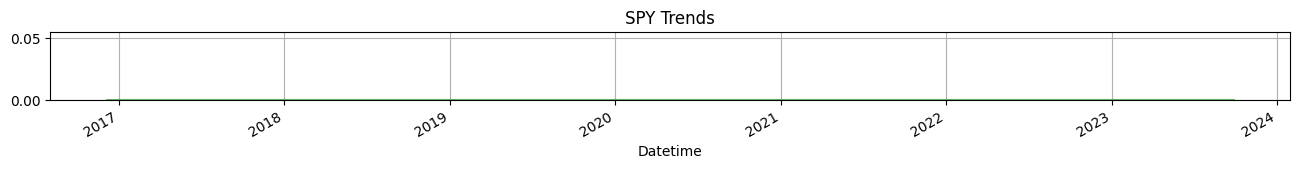

In [203]:
# benchmark_trends = trends(benchmarkdf, **trend_kwargs)
benchmark_trends, benchmark_exits = trends_rsi(benchmarkdf, **trend_rsi)

print(benchmark_trends)
benchmark_trends.copy().astype(int).plot(figsize=(16, 1), kind="area", color=["green"], alpha=0.45, title=f"{benchmarkdf.name} Trends", grid=True)

<AxesSubplot:title={'center':'UDOW Trends'}, xlabel='Datetime'>

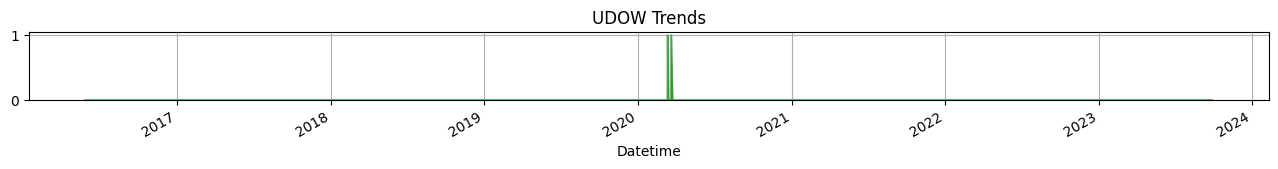

In [79]:
asset_trends = trends_rsi(assetdf, **trend_rsi)
asset_trends.copy().astype(int).plot(figsize=(16, 1), kind="area", color=["green"], alpha=0.45, title=f"{assetdf.name} Trends", grid=True)

### **Trend Signals** 
Given a _Trend_, **Trend Signals** returns the _Trend_, _Trades_, _Entries_ and _Exits_ as boolean integers. When ```asbool=True```, it returns _Trends_, _Entries_ and _Exits_ as boolean values which is helpful when combined with the [**vectorbt**](https://github.com/polakowo/vectorbt) backtesting package.

In [54]:
# trade_offset = 0 for Live Signals (close is last price)
# trade_offset = 1 for Backtesting
LIVE = 0
# print(benchmark_trends.columns)
print(benchmark_trends.tail())
benchmark_signals = assetdf.ta.tsignals(benchmark_trends, asbool=True, trade_offset=LIVE, append=True)
benchmark_signals.tail()

Datetime
2023-09-22 04:00:00+00:00    True
2023-09-25 04:00:00+00:00    True
2023-09-26 04:00:00+00:00    True
2023-09-27 04:00:00+00:00    True
2023-09-28 04:00:00+00:00    True
Name: (12, 99), dtype: bool


,TS_Trends,TS_Trades,TS_Entries,TS_Exits
Datetime,,,,
2023-09-22 04:00:00+00:00,True,0,False,False
2023-09-25 04:00:00+00:00,True,0,False,False
2023-09-26 04:00:00+00:00,True,0,False,False
2023-09-27 04:00:00+00:00,True,0,False,False
2023-09-28 04:00:00+00:00,True,0,False,False


In [55]:
asset_signals = assetdf.ta.tsignals(asset_trends, asbool=True, trade_offset=LIVE, append=True)
asset_signals.tail()

,TS_Trends,TS_Trades,TS_Entries,TS_Exits
Datetime,,,,
2023-09-22 04:00:00+00:00,True,0,False,False
2023-09-25 04:00:00+00:00,True,0,False,False
2023-09-26 04:00:00+00:00,True,0,False,False
2023-09-27 04:00:00+00:00,True,0,False,False
2023-09-28 04:00:00+00:00,True,0,False,False


## Creating **vectorbt** Portfolios
* [**vectorbt** Portfolio Options](https://polakowo.io/vectorbt/docs/portfolio/base.html)

### Buy 'N Hold Portfolios with their Single Trade and Performance Statistics

In [56]:
# Benchmark Buy and Hold (BnH) Strategy
benchmarkpf_bnh = vbt.Portfolio.from_holding(benchmarkdf.Close)
print(trade_table(benchmarkpf_bnh))
combine_stats(benchmarkpf_bnh, benchmarkdf.name, "Buy and Hold", LIVE)


Last 1 of 1 Trades
   status  direction  ...  entry_fees  exit_fees
0       0          0  ...         0.0        0.0

[1 rows x 9 columns]

None


Run Time              Tuesday October 3, 2023, NYSE: 13:20:06
Mode                                                     TEST
Strategy                                         Buy and Hold
Direction                                            longonly
Symbol                                                    SPY
                                       ...                   
Tail Ratio                                           0.894215
Common Sense Ratio                                   1.056537
Value at Risk                                        -0.01804
Alpha                                                     0.0
Beta                                                      1.0
Length: 36, dtype: object

In [57]:
# Asset Buy and Hold (BnH) Strategy
assetpf_bnh = vbt.Portfolio.from_holding(assetdf.Close)
print(trade_table(assetpf_bnh))
combine_stats(assetpf_bnh, assetdf.name, "Buy and Hold", LIVE)


Last 1 of 1 Trades
   status  direction  ...  entry_fees  exit_fees
0       0          0  ...         0.0        0.0

[1 rows x 9 columns]

None


Run Time              Tuesday October 3, 2023, NYSE: 13:20:07
Mode                                                     TEST
Strategy                                         Buy and Hold
Direction                                            longonly
Symbol                                                   UDOW
                                       ...                   
Tail Ratio                                           0.922159
Common Sense Ratio                                   1.131253
Value at Risk                                        -0.05178
Alpha                                                     0.0
Beta                                                      1.0
Length: 36, dtype: object

### Signal Portfolios with their Last 'k' Trades and Performance Statistics

In [58]:
# Benchmark Portfolio from Trade Signals
benchmarkpf_signals = vbt.Portfolio.from_signals(
    benchmarkdf.Close,
    signal_args=(vbt.Rep("entries"), vbt.Rep("exits")),
    entries=benchmark_trends,
    exits=benchmark_exits,
#     entries=benchmark_signals.TS_Entries,
#     exits=benchmark_signals.TS_Exits,
)
trade_table(benchmarkpf_signals, k=10)
combine_stats(benchmarkpf_signals, benchmarkdf.name, "Long Strategy", LIVE)


Last 10 of 9 Trades
   status  direction  ...  entry_fees  exit_fees
0       1          0  ...         0.0        0.0
1       1          0  ...         0.0        0.0
2       1          0  ...         0.0        0.0
3       1          0  ...         0.0        0.0
4       1          0  ...         0.0        0.0
5       1          0  ...         0.0        0.0
6       1          0  ...         0.0        0.0
7       1          0  ...         0.0        0.0
8       0          0  ...         0.0        0.0

[9 rows x 9 columns]



Run Time              Tuesday October 3, 2023, NYSE: 13:20:11
Mode                                                     TEST
Strategy                                        Long Strategy
Direction                                            longonly
Symbol                                                    SPY
                                       ...                   
Tail Ratio                                           1.043939
Common Sense Ratio                                   1.185544
Value at Risk                                       -0.013688
Alpha                                                0.009421
Beta                                                 0.706433
Length: 45, dtype: object

In [59]:
# Asset Portfolio from Trade Signals
assetpf_signals = vbt.Portfolio.from_signals(
    assetdf.Close,
    signal_args=(vbt.Rep("entries"), vbt.Rep("exits")),
    entries=asset_trends,
    exits=asset_exits,    
#     entries=asset_signals.TS_Entries,
#     exits=asset_signals.TS_Exits,
)
# print(assetpf_signals)
trade_table(assetpf_signals, k=5)
combine_stats(assetpf_signals, assetdf.name, "Long Strategy", LIVE)
# print(assetpf_signals.trades.records_readable[["Entry Index", "Exit Index", "PnL"]])



Last 5 of 10 Trades
   status  direction  ...  entry_fees  exit_fees
5       1          0  ...         0.0        0.0
6       1          0  ...         0.0        0.0
7       1          0  ...         0.0        0.0
8       1          0  ...         0.0        0.0
9       0          0  ...         0.0        0.0

[5 rows x 9 columns]



Run Time              Tuesday October 3, 2023, NYSE: 13:20:12
Mode                                                     TEST
Strategy                                        Long Strategy
Direction                                            longonly
Symbol                                                   UDOW
                                       ...                   
Tail Ratio                                           1.047714
Common Sense Ratio                                   1.426391
Value at Risk                                       -0.043861
Alpha                                                0.147106
Beta                                                 0.839439
Length: 45, dtype: object

## Buy and Hold Plots

In [32]:
vbt.settings.set_theme("seaborn")

### Benchmark

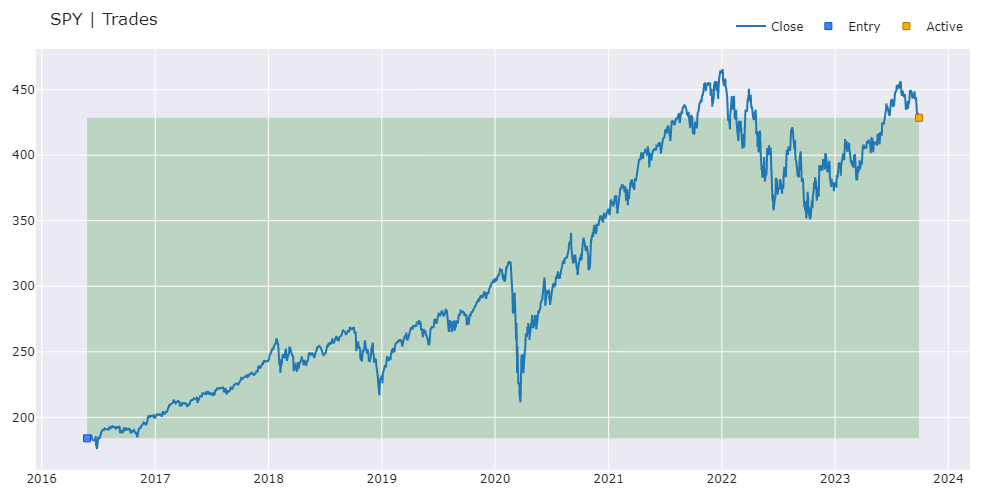

In [33]:
benchmarkpf_bnh.trades.plot(title=f"{benchmarkdf.name} | Trades", height=cheight, width=cwidth).show_png()

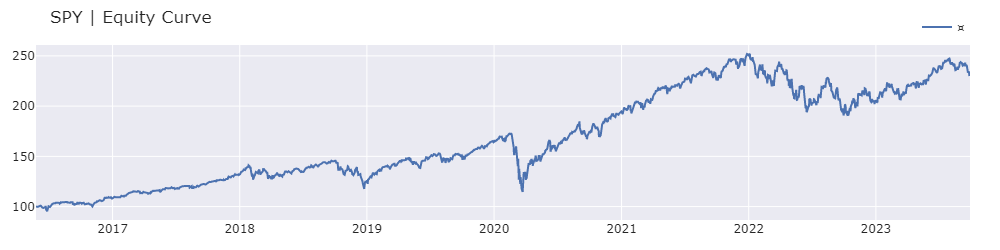

In [27]:
benchmarkpf_bnh.value().vbt.plot(title=f"{benchmarkdf.name} | Equity Curve", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

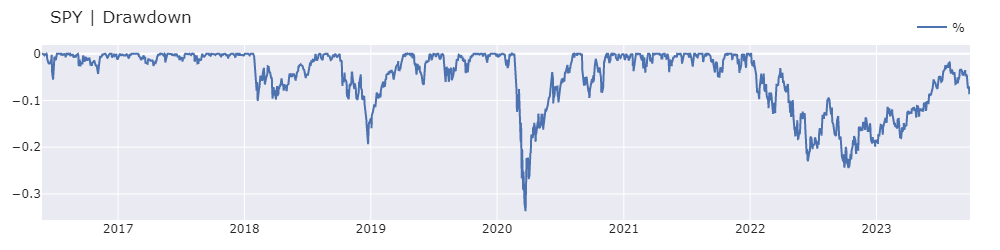

In [28]:
benchmarkpf_bnh.drawdown().vbt.plot(title=f"{benchmarkdf.name} | Drawdown", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

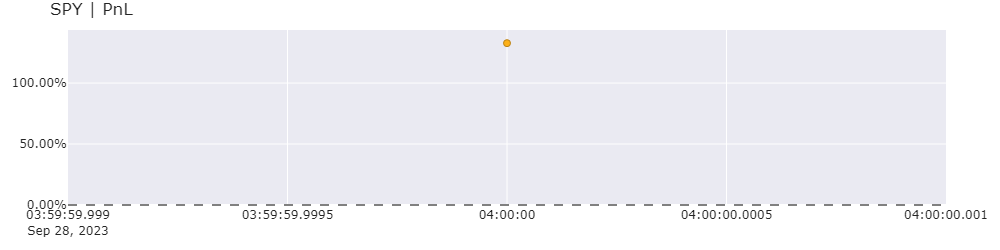

In [29]:
benchmarkpf_bnh.trades.plot_pnl(title=f"{benchmarkdf.name} | PnL", height=cheight // 2, width=cwidth).show_png()

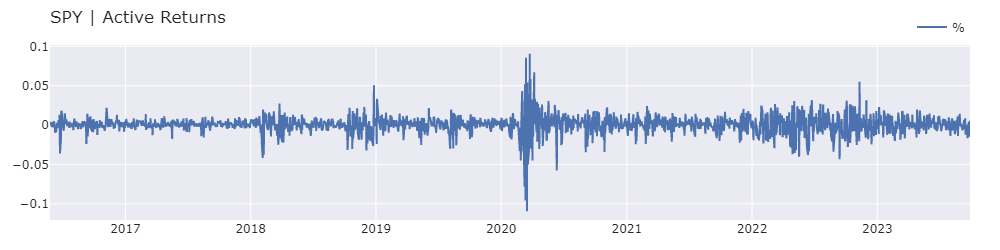

In [30]:
benchmarkpf_bnh.asset_returns().vbt.plot(title=f"{benchmarkdf.name} | Active Returns", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

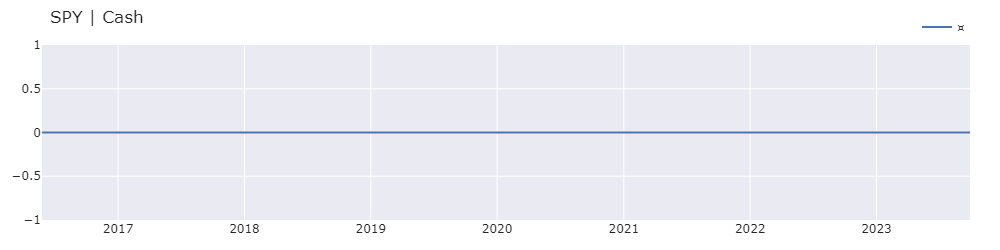

In [31]:
benchmarkpf_bnh.cash().vbt.plot(title=f"{benchmarkdf.name} | Cash", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

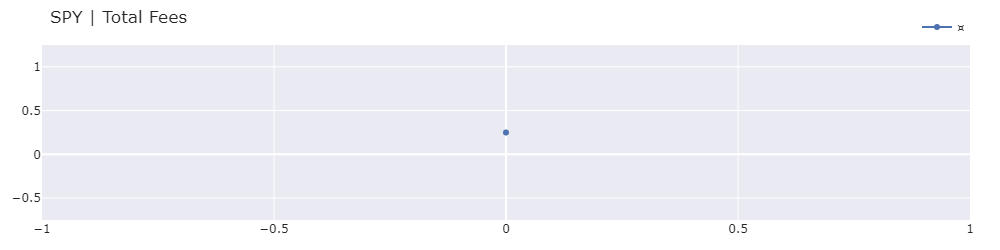

In [32]:
total_assetfees = benchmarkpf_bnh.trades.records_readable["Entry Fees"] + benchmarkpf_bnh.trades.records_readable["Exit Fees"]
total_assetfees.vbt.plot(title=f"{benchmarkdf.name} | Total Fees", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

### Asset

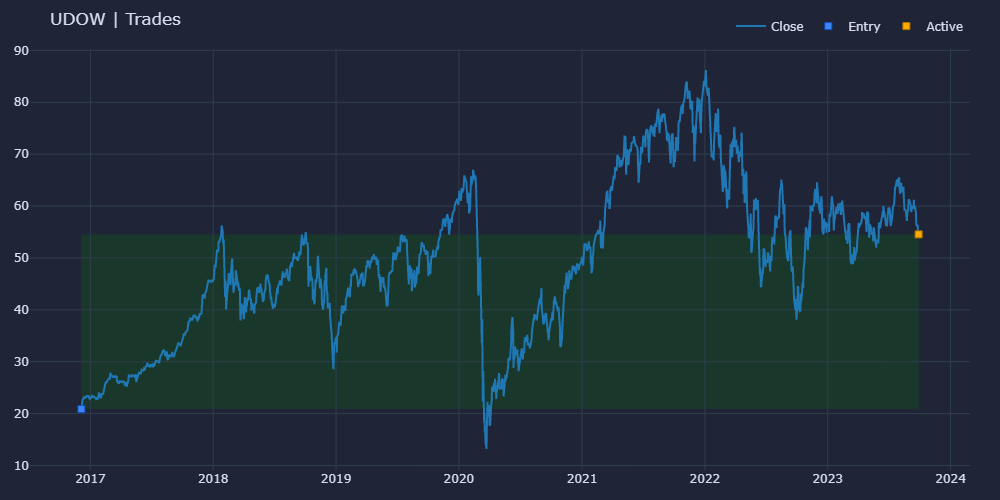

In [60]:
fig = assetpf_bnh.trades.plot(title=f"{assetdf.name} | Trades", height=cheight, width=cwidth).show_png()

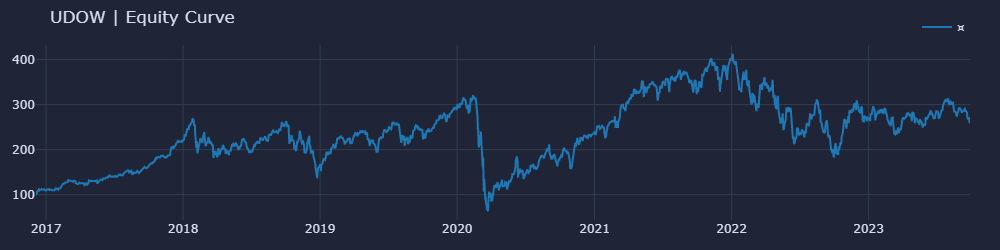

In [61]:
assetpf_bnh.value().vbt.plot(title=f"{assetdf.name} | Equity Curve", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

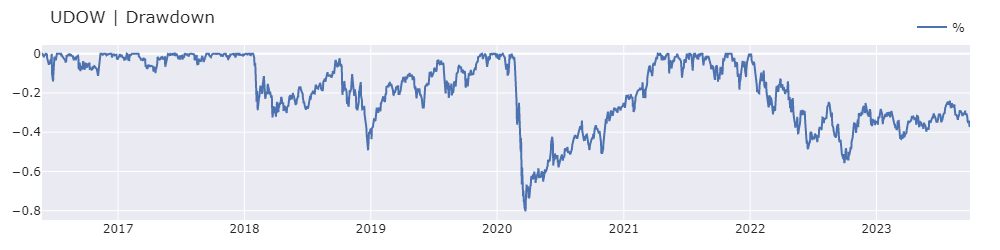

In [35]:
assetpf_bnh.drawdown().vbt.plot(title=f"{assetdf.name} | Drawdown", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

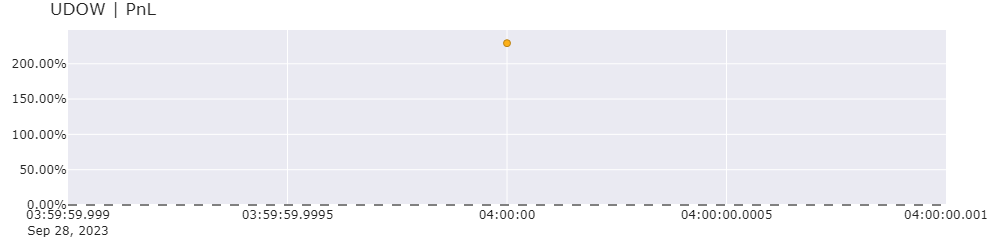

In [36]:
assetpf_bnh.trades.plot_pnl(title=f"{assetdf.name} | PnL", height=cheight // 2, width=cwidth).show_png()

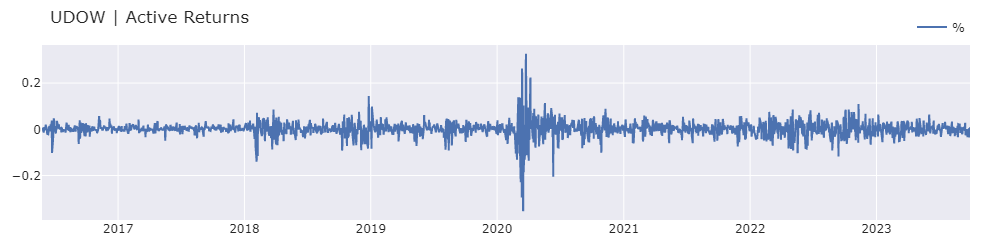

In [37]:
assetpf_bnh.asset_returns().vbt.plot(title=f"{assetdf.name} | Active Returns", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

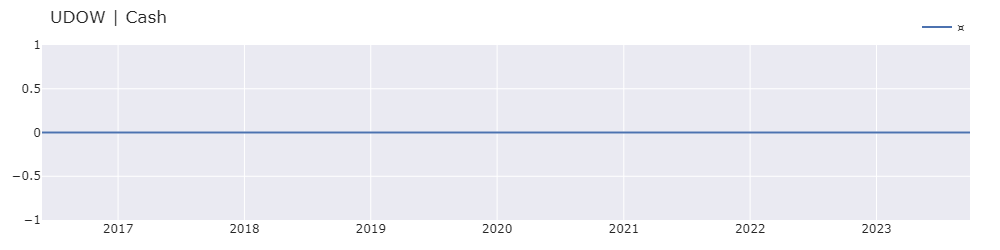

In [38]:
assetpf_bnh.cash().vbt.plot(title=f"{assetdf.name} | Cash", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

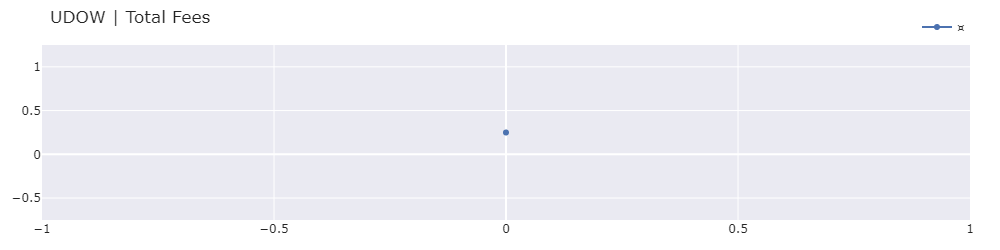

In [39]:
total_assetfees = assetpf_bnh.trades.records_readable["Entry Fees"] + assetpf_bnh.trades.records_readable["Exit Fees"]
total_assetfees.vbt.plot(title=f"{assetdf.name} | Total Fees", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

## Signal Plots

In [23]:
vbt.settings.set_theme("dark")

### Benchmark

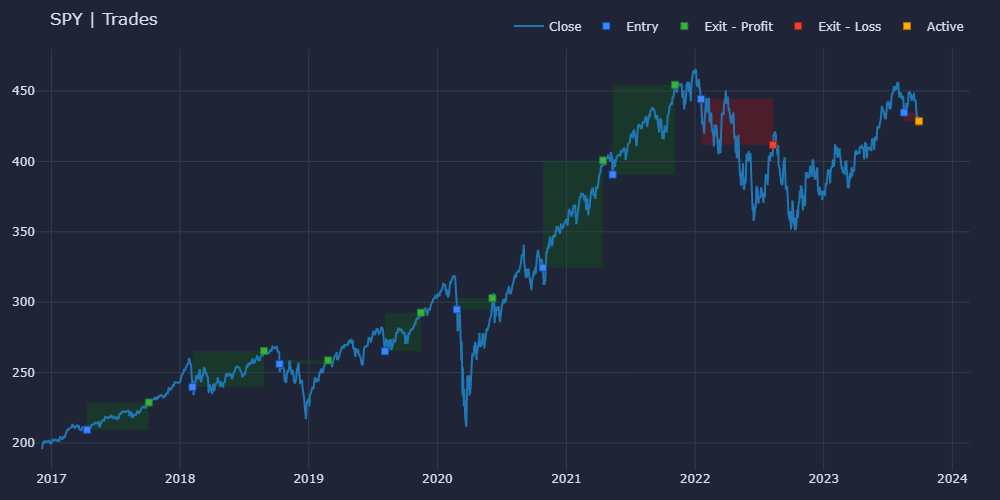

In [24]:
benchmarkpf_signals.trades.plot(title=f"{benchmarkdf.name} | Trades", height=cheight, width=cwidth).show_png()

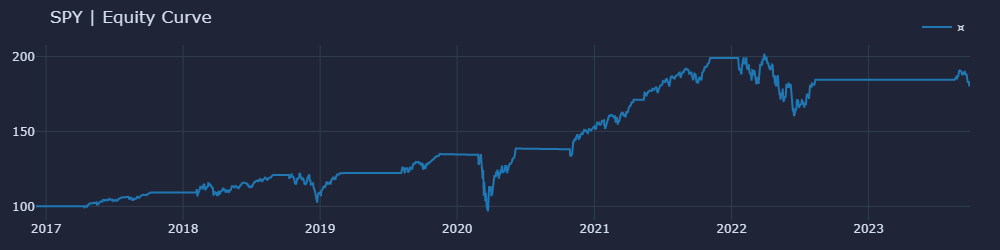

In [25]:
benchmarkpf_signals.value().vbt.plot(title=f"{benchmarkdf.name} | Equity Curve", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

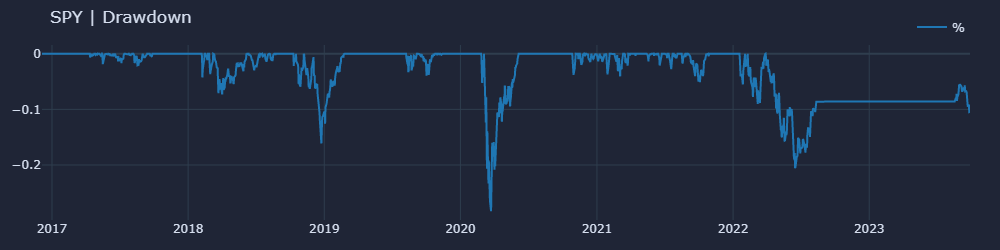

In [26]:
benchmarkpf_signals.drawdown().vbt.plot(title=f"{benchmarkdf.name} | Drawdown", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

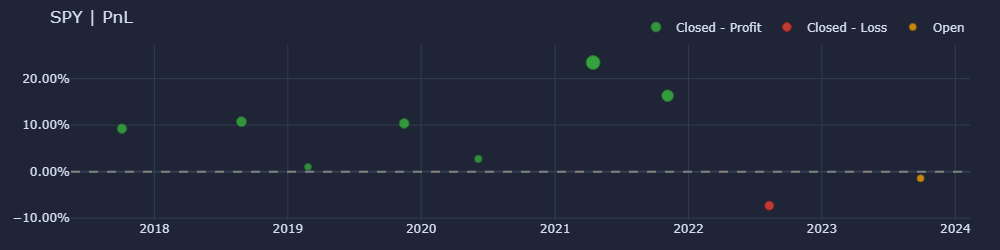

In [27]:
benchmarkpf_signals.trades.plot_pnl(title=f"{benchmarkdf.name} | PnL", height=cheight // 2, width=cwidth).show_png()

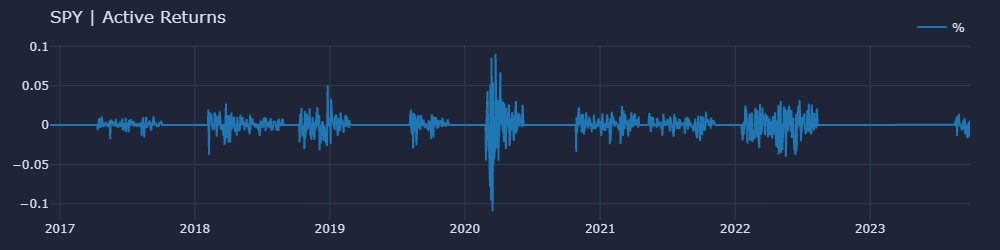

In [28]:
benchmarkpf_signals.asset_returns().vbt.plot(title=f"{benchmarkdf.name} | Active Returns", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

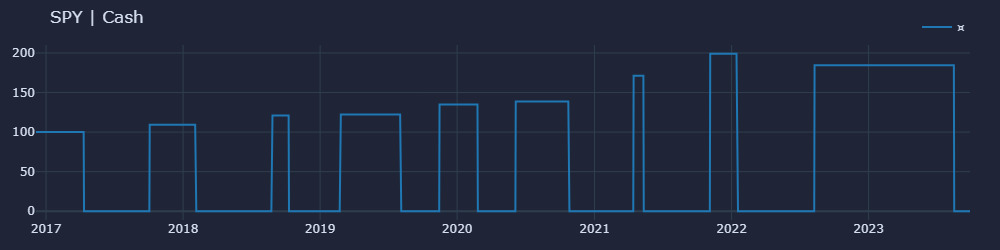

In [29]:
benchmarkpf_signals.cash().vbt.plot(title=f"{benchmarkdf.name} | Cash", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

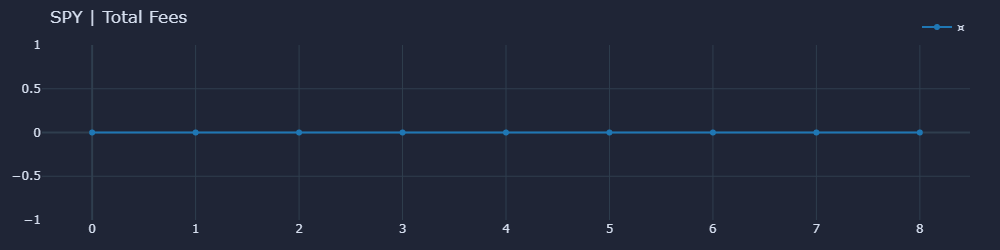

In [30]:
total_assetfees = benchmarkpf_signals.trades.records_readable["Entry Fees"] + benchmarkpf_signals.trades.records_readable["Exit Fees"]
total_assetfees.vbt.plot(title=f"{benchmarkdf.name} | Total Fees", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

### Asset

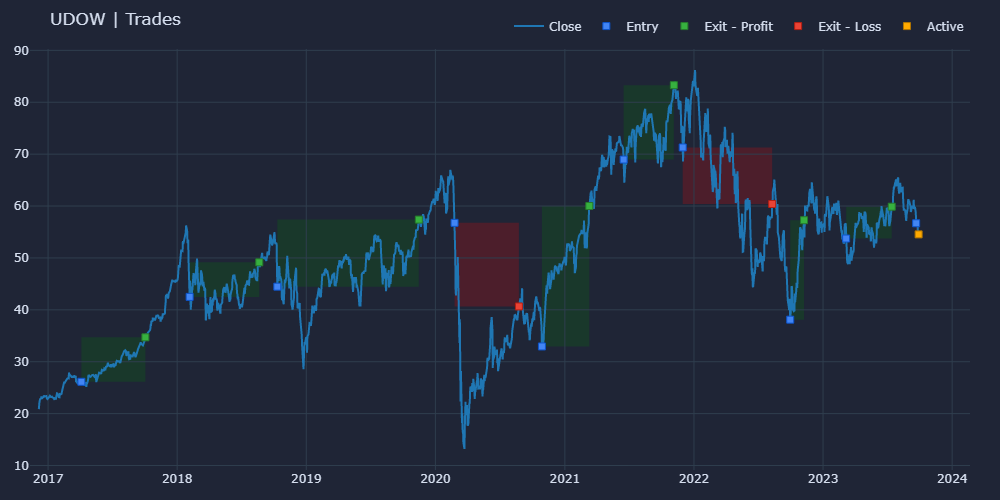

In [31]:
assetpf_signals.trades.plot(title=f"{assetdf.name} | Trades", height=cheight, width=cwidth).show_png()

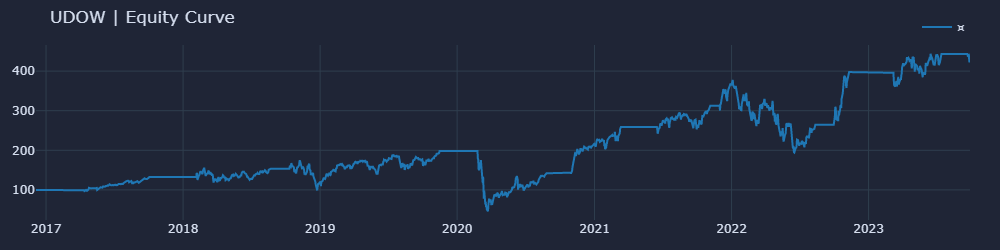

In [32]:
assetpf_signals.value().vbt.plot(title=f"{assetdf.name} | Equity Curve", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

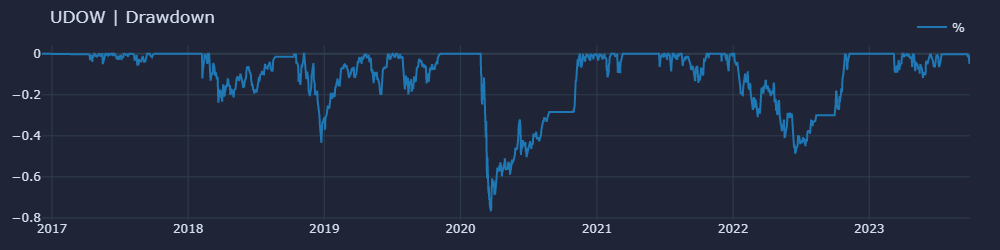

In [33]:
assetpf_signals.drawdown().vbt.plot(title=f"{assetdf.name} | Drawdown", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

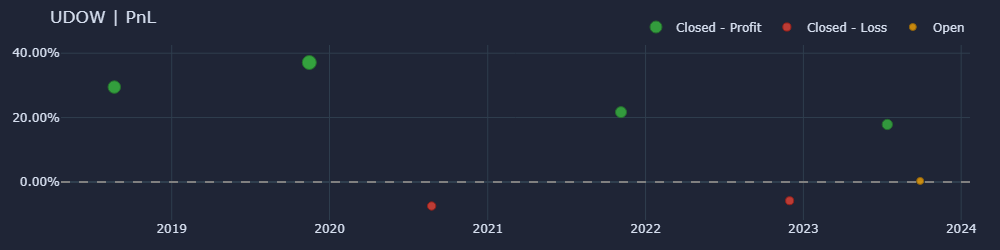

In [36]:
assetpf_signals.trades.plot_pnl(title=f"{assetdf.name} | PnL", height=cheight // 2, width=cwidth).show_png()

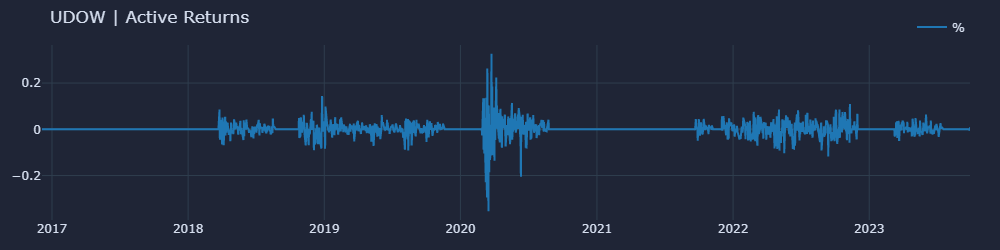

In [37]:
assetpf_signals.asset_returns().vbt.plot(title=f"{assetdf.name} | Active Returns", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

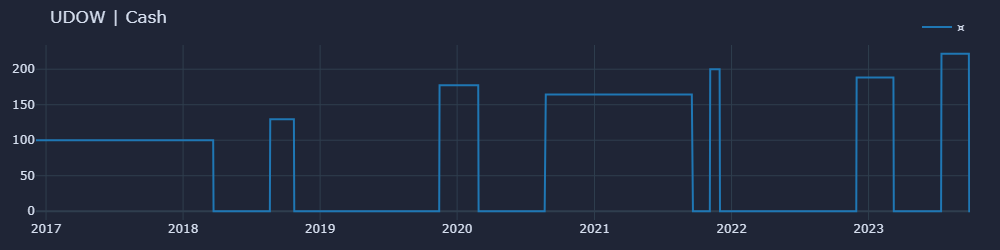

In [38]:
assetpf_signals.cash().vbt.plot(title=f"{assetdf.name} | Cash", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

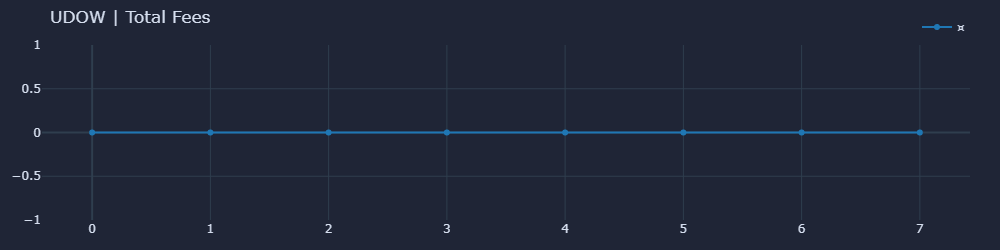

In [38]:
total_assetfees = assetpf_signals.trades.records_readable["Entry Fees"] + assetpf_signals.trades.records_readable["Exit Fees"]
total_assetfees.vbt.plot(title=f"{assetdf.name} | Total Fees", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

# Disclaimer
* All investments involve risk, and the past performance of a security, industry, sector, market, financial product, trading strategy, or individual’s trading does not guarantee future results or returns. Investors are fully responsible for any investment decisions they make. Such decisions should be based solely on an evaluation of their financial circumstances, investment objectives, risk tolerance, and liquidity needs.

* Any opinions, news, research, analyses, prices, or other information offered is provided as general market commentary, and does not constitute investment advice. I will not accept liability for any loss or damage, including without limitation any loss of profit, which may arise directly or indirectly from use of or reliance on such information.